#### Simple CNN for image classification

In [1]:
import torch
from torch import nn

In [2]:

def create_model(img_channels = 3):
    model = nn.Sequential()
    model.add_module('conv0', nn.Conv2d(in_channels=img_channels, out_channels=16, kernel_size=5, padding='same'))
    model.add_module('relu0', nn.ReLU())
    model.add_module('pool0', nn.MaxPool2d(kernel_size=2))

    model.add_module('conv1', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same'))
    model.add_module('relu1', nn.ReLU())
    model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

    model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'))
    model.add_module('relu2', nn.ReLU())
    model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

    model.add_module('flatten', nn.Flatten())
    model.add_module('ln0', nn.Linear(4096, out_features=1024))
    model.add_module('relu4', nn.ReLU())
    model.add_module('ln1', nn.Linear(1024, out_features=10))
    return model


### Load and prepare an image dataset

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
image_path = './data/eurosat'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5))])
eurosat_dataset = datasets.EuroSAT(root=image_path, transform=transform, download=True)

#Randomize the dataset
torch.manual_seed(1)
train_len = int(0.85 * len(eurosat_dataset)) - int(0.85 * len(eurosat_dataset) * 0.2)
valid_len = int(0.85 * len(eurosat_dataset) * 0.2)
test_len = len(eurosat_dataset) - train_len - valid_len
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(eurosat_dataset, [train_len, valid_len, test_len])

#Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=20)


#### Create the training loop function

In [4]:
def train(model, epochs, train_dl, valid_dl, gpu=False):
    if gpu:
        model.cuda()
    else:
        model.cpu()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_hist_train = [0] * epochs
    accuracy_hist_train = [0] * epochs

    loss_hist_valid = [0] * epochs
    accuracy_hist_valid = [0] * epochs

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            if gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            
            loss.backward() #Calculate tensor gradients with backpropagation
            optimizer.step() #Apply updates to weights using the optimizer gradient descent specif impl algorithm
            optimizer.zero_grad() #Reset the gradients for the next iteration
            
            #Calculate and save matrics
            loss_hist_train[epoch] += loss.item() * y_batch.size(0) #Add the loss to the loss history
            is_correct = (torch.argmax(pred, dim=1) == y_batch).cpu().float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= train_len
        accuracy_hist_train[epoch] /= train_len

        model.eval() #Set the model to evaluation mode
        with torch.no_grad(): #Turn off gradients
            for x_batch, y_batch in valid_dl:
                if gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += (loss.item() * y_batch.size(0))
                is_correct = (torch.argmax(pred, dim=1) == y_batch).cpu().float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= valid_len
            accuracy_hist_valid[epoch] /= valid_len
        print(f'Epoch {epoch+1}/{epochs} accuracy: {accuracy_hist_train[epoch]:4f} valid_accuracy: {accuracy_hist_valid[epoch]:4f}')
    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid

In [17]:
def evaluate_model(model, data_loader, gpu=False):
    if gpu:
        model.cuda()
    else:
        model.cpu()    
    model.eval()
    y_list = []
    pred_list = []
    for x_batch, y_batch in data_loader:
        if gpu:
            x_batch = x_batch.cuda()
        pred = model(x_batch)
        pred_list.append(torch.argmax(pred, dim=1).cpu())
        y_list.append(y_batch)
    preds = torch.cat(pred_list, dim=0)
    y_true = torch.cat(y_list, dim=0)    
    #Calculate the accuracy
    is_correct = (preds == y_true).float()
    accuracy = is_correct.sum() / is_correct.numel()
    print(f'Accuracy: {accuracy:4f}')
    return accuracy

In [32]:
gpu_model = create_model()

#Measure the time it takes to train the model
import time
start = time.time()
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = train(gpu_model, epochs=20, train_dl=train_loader, valid_dl=valid_loader, gpu=True)
end = time.time()
print(f'Time to train: {end-start}')

Epoch 1/20 accuracy: 0.437364 valid_accuracy: 0.505229
Epoch 2/20 accuracy: 0.672495 valid_accuracy: 0.533333
Epoch 3/20 accuracy: 0.733007 valid_accuracy: 0.635730
Epoch 4/20 accuracy: 0.753867 valid_accuracy: 0.653813
Epoch 5/20 accuracy: 0.779031 valid_accuracy: 0.653595
Epoch 6/20 accuracy: 0.791013 valid_accuracy: 0.699564
Epoch 7/20 accuracy: 0.816939 valid_accuracy: 0.671024
Epoch 8/20 accuracy: 0.844281 valid_accuracy: 0.704357
Epoch 9/20 accuracy: 0.849728 valid_accuracy: 0.656645
Epoch 10/20 accuracy: 0.851362 valid_accuracy: 0.630283
Epoch 11/20 accuracy: 0.875163 valid_accuracy: 0.745098
Epoch 12/20 accuracy: 0.895261 valid_accuracy: 0.720261
Epoch 13/20 accuracy: 0.912200 valid_accuracy: 0.715904
Epoch 14/20 accuracy: 0.926852 valid_accuracy: 0.735512
Epoch 15/20 accuracy: 0.928377 valid_accuracy: 0.673203
Epoch 16/20 accuracy: 0.935948 valid_accuracy: 0.737473
Epoch 17/20 accuracy: 0.965686 valid_accuracy: 0.724183
Epoch 18/20 accuracy: 0.969009 valid_accuracy: 0.700218
E

In [24]:
cpu_model = create_model()

#Measure the time it takes to train the model
import time
start = time.time()
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = train(cpu_model, epochs=20, train_dl=train_loader, valid_dl=valid_loader, gpu=False)
end = time.time()
print(f'Time to train: {end-start}')

Epoch 1/20 accuracy: 0.431155 valid_accuracy: 0.477560
Epoch 2/20 accuracy: 0.636547 valid_accuracy: 0.533551
Epoch 3/20 accuracy: 0.727887 valid_accuracy: 0.646841
Epoch 4/20 accuracy: 0.740632 valid_accuracy: 0.624619
Epoch 5/20 accuracy: 0.770425 valid_accuracy: 0.690632
Epoch 6/20 accuracy: 0.791122 valid_accuracy: 0.694336
Epoch 7/20 accuracy: 0.806481 valid_accuracy: 0.691939
Epoch 8/20 accuracy: 0.813780 valid_accuracy: 0.691068
Epoch 9/20 accuracy: 0.831481 valid_accuracy: 0.691721
Epoch 10/20 accuracy: 0.842320 valid_accuracy: 0.734641
Epoch 11/20 accuracy: 0.856699 valid_accuracy: 0.714815
Epoch 12/20 accuracy: 0.873802 valid_accuracy: 0.708497
Epoch 13/20 accuracy: 0.891068 valid_accuracy: 0.701743
Epoch 14/20 accuracy: 0.905174 valid_accuracy: 0.754466
Epoch 15/20 accuracy: 0.923257 valid_accuracy: 0.743573
Epoch 16/20 accuracy: 0.923312 valid_accuracy: 0.725272
Epoch 17/20 accuracy: 0.939107 valid_accuracy: 0.705665
Epoch 18/20 accuracy: 0.953214 valid_accuracy: 0.744662
E

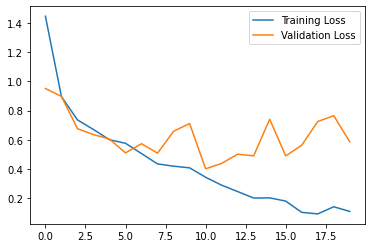

In [33]:
import matplotlib.pyplot as plt
#Plot the loss
plt.plot(loss_hist_train, label='Training Loss')
plt.plot(loss_hist_valid, label='Validation Loss')
plt.legend()
plt.show()


In [34]:
evaluate_model(gpu_model, test_loader, gpu=True)

Accuracy: 0.832026


tensor(0.8320)

In [35]:
evaluate_model(cpu_model, test_loader, gpu=False)

Accuracy: 0.828540


tensor(0.8285)

In [9]:
import pytorch_lightning as pl
loss_fn = nn.CrossEntropyLoss()
class ClsModel(pl.LightningModule):
    def __init__(self, img_channels=3) -> None:
        super().__init__()
        model = nn.Sequential()
        model.add_module('conv0', nn.Conv2d(in_channels=img_channels, out_channels=16, kernel_size=5, padding='same'))
        model.add_module('relu0', nn.ReLU())
        model.add_module('pool0', nn.MaxPool2d(kernel_size=2))

        model.add_module('conv1', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same'))
        model.add_module('relu1', nn.ReLU())
        model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

        model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'))
        model.add_module('relu2', nn.ReLU())
        model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

        model.add_module('flatten', nn.Flatten())
        model.add_module('ln0', nn.Linear(4096, out_features=1024))
        model.add_module('relu4', nn.ReLU())
        model.add_module('ln1', nn.Linear(1024, out_features=10))
        self.model = model
       
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def step(self, batch):
        x, y = batch
        y_pred = self.forward(x)
        return loss_fn(y_pred, y)

    def training_step(self, train_batch, batch_idx):
        loss = self.step(train_batch)
        self.log('train_loss', loss)
        return loss  

    def validation_step(self, valid_batch, batch_idx):
        loss = self.step(valid_batch)
        self.log('valid_loss', loss)
        return loss       


In [31]:
lmodel = ClsModel()
trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1)
trainer.fit(lmodel, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 4.3 M 
-------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.084    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 176/176 [00:02<00:00, 65.65it/s, loss=0.122, v_num=4] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 176/176 [00:02<00:00, 63.57it/s, loss=0.122, v_num=4]


In [36]:
evaluate_model(lmodel, test_loader, gpu=True)

Accuracy: 0.822876


tensor(0.8229)